In [190]:
# binary search, then off by one resolution
def solve_(t, N):
    # your solution here
    
    d = 1/((t/100)/(1+(t/100)))
    ratio = (1+t/100)

    sum = (N)*d
    # sum = N*(d+an)/2
    isum = int(sum)

#     log(sum)

    root = int(sum/ratio)
    impossible = set([isum+i for i in [-1,0,1]])

    for i in [-1,0,1,2]:
        val = int((root+i)*ratio)
        impossible.discard(val)

#     log(impossible)
#     assert len(impossible) == 1

    for val in impossible:
        return val

In [192]:
for t in range(1,51):
    impossible = set(range(1,100000))
    for a in range(1,100000):
        val = int((1+t/100)*a)
        impossible.discard(val)
    impossible = sorted(impossible)
    for i,x in enumerate(impossible, start=1):
        if x != solve_(t, i):
            print(x, t, i)
            print(solve_(t, i))
            assert False
#     ref = [int(x) for x in np.arange(1/((t/100)/(1+(t/100))),100000,1/((t/100)/(1+(t/100))))]
# #     print(impossible)
# #     print(ref)
#     print(impossible[len(ref)-1] - ref[-1])
# #         print(t, "nope")
# #         print(impossible[:len(ref)])
# #         print(ref)
#     diff = [y-x for x,y in zip(impossible,impossible[1:])]
#     for x in range(1,1000):
#         pattern = diff[:x]*100
#         if pattern == diff[:len(pattern)]:
#             break
# #     print(diff[:20])
# #     if t == 15:
# #         break
#     print(t, x, set(diff))

In [220]:
t = 6
1/((t/100)/(1+(t/100))) * 10**9 - 1

17666666665.666668

In [223]:
3/140

0.02142857142857143

In [221]:
100999999999
101000000000.0

101000000000.0

In [222]:
# impossible

In [165]:
import numpy as np

In [131]:
print(int(i))

7
15
23
30
38
46
53
61
69
76
84
92
99
107
115
122
130
138
145
153
161
168
176
184
191
199
207
214
222
230
237
245
253
260
268
276
283
291
299
306
314
322
329
337
345
352
360
368
375
383
391
398
406
414
421
429
437
444
452
460
467
475
483
490
498
506
513
521
529
536
544
552
559
567
575
582
590
598
605
613
621
628
636
644
651
659
667
674
682
690
697
705
713
720
728
736
743
751
759
766
774
782
789
797
805
812
820
828
835
843
851
858
866
874
881
889
897
904
912
920
927
935
943
950
958
966
973
981
989
996


In [121]:
7*1.15

8.049999999999999

In [117]:
impossible

[7,
 15,
 22,
 30,
 38,
 45,
 53,
 61,
 68,
 76,
 84,
 91,
 99,
 107,
 115,
 122,
 130,
 137,
 145,
 153,
 160,
 168,
 176,
 183,
 191,
 199,
 207,
 214,
 222,
 230,
 237,
 245,
 253,
 260,
 268,
 275,
 283,
 291,
 298,
 306,
 314,
 321,
 329,
 337,
 344,
 352,
 360,
 367,
 375,
 383,
 391,
 398,
 406,
 414,
 421,
 429,
 437,
 444,
 452,
 460,
 467,
 475,
 483,
 490,
 498,
 506,
 513,
 521,
 528,
 536,
 544,
 551,
 559,
 567,
 574,
 582,
 590,
 597,
 605,
 613,
 620,
 628,
 636,
 643,
 651,
 659,
 666,
 674,
 682,
 689,
 697,
 705,
 712,
 720,
 728,
 735,
 743,
 751,
 759,
 766,
 774,
 782,
 789,
 797,
 805,
 812,
 820,
 828,
 835,
 843,
 851,
 858,
 866,
 874,
 881,
 889,
 897,
 904,
 912,
 920,
 927,
 935,
 943,
 950,
 958,
 966,
 973,
 981,
 989,
 996,
 1004,
 1012,
 1019,
 1027,
 1034,
 1042,
 1050,
 1057,
 1065,
 1073,
 1080,
 1088,
 1096,
 1103,
 1111,
 1119,
 1126,
 1134,
 1142,
 1149,
 1157,
 1165,
 1172,
 1180,
 1188,
 1195,
 1203,
 1211,
 1218,
 1226,
 1234,
 1241,
 1249,
 12

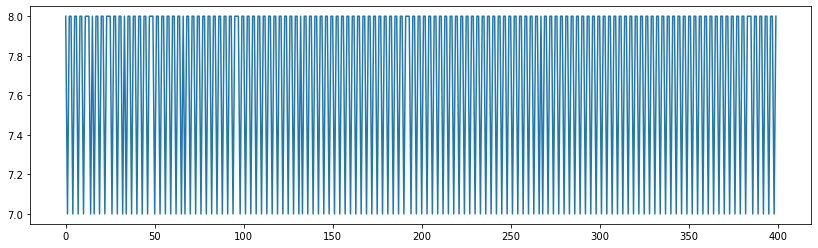

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,4))
plt.plot(diff[:400])

{101}

In [2]:
from collections import defaultdict

In [3]:
g = defaultdict(lambda: -1)

In [6]:
g[1,1] = (1,1)

In [9]:
g[1,2] += 1

In [41]:
from flask import Flask, request
app = Flask(__name__)
@app.route('/', methods=['POST'])
def result():
    print(request.form['foo']) # should display 'bar'
    return 'Received !' # response to your request

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


OSError: [Errno 9] Bad file descriptor

In [40]:
import requests
r = requests.post("http://yoururl/post", data={'foo': 'bar'})
# And done.
print(r.text) # displays the result body.

ConnectionError: HTTPConnectionPool(host='yoururl', port=80): Max retries exceeded with url: /post (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f93caac3410>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [38]:
# https://gist.github.com/jmhobbs/11276249

import os
import socket
import time

socket_path = './socket'

if os.path.exists(socket_path):
    os.remove(socket_path)

with socket.socket(socket.AF_UNIX, socket.SOCK_STREAM) as sock:
    sock.bind(socket_path)
    sock.listen()
    while True:
        conn, _addr = sock.accept()
        data = conn.recv(1024)
        time.sleep(1) # do some work
        print(data)
        conn.send(data)
        conn.close()

KeyboardInterrupt: 

In [35]:
%tb
# import main Flask class and request object
from flask import Flask, request

# create the Flask app
app = Flask(__name__)

@app.route('/query-example')
def query_example():
    return 'Query String Example'

@app.route('/form-example')
def form_example():
    return 'Form Data Example'

@app.route('/json-example')
def json_example():
    return 'JSON Object Example'

if __name__ == '__main__':
    # run app in debug mode on port 5000
    app.run(debug=True, port=50010)

SystemExit: 1

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


OSError: [Errno 48] Address already in use

In [29]:
import socket
import sys
import json

# HOST, PORT = "192.168.0.1", 9999
HOST, PORT = "127.0.0.1", 9999

#m ='{"id": 2, "name": "abc"}'
m = {"id": 2, "name": "abc"} # a real dict.


data = json.dumps(m)

# Create a socket (SOCK_STREAM means a TCP socket)
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

try:
    # Connect to server and send data
    sock.connect((HOST, PORT))
    sock.sendall(bytes(data,encoding="utf-8"))


    # Receive data from the server and shut down
    received = sock.recv(1024)
    received = received.decode("utf-8")

finally:
    sock.close()

print("Sent:     {}".format(data))
print("Received: {}".format(received))

ConnectionRefusedError: [Errno 61] Connection refused

In [21]:
from http.server import BaseHTTPRequestHandler, HTTPServer
# import SocketServer
import json
import cgi

class Server(BaseHTTPRequestHandler):
    def _set_headers(self):
        self.send_response(200)
        self.send_header('Content-type', 'application/json')
        self.end_headers()
        
    def do_HEAD(self):
        self._set_headers()
        
    # GET sends back a Hello world message
    def do_GET(self):
        self._set_headers()
        self.wfile.write(json.dumps({'hello': 'world', 'received': 'ok'}))
        
    # POST echoes the message adding a JSON field
    def do_POST(self):
        ctype, pdict = cgi.parse_header(self.headers.getheader('content-type'))
        
        # refuse to receive non-json content
        if ctype != 'application/json':
            self.send_response(400)
            self.end_headers()
            return
            
        # read the message and convert it into a python dictionary
        length = int(self.headers.getheader('content-length'))
        message = json.loads(self.rfile.read(length))
        
        # add a property to the object, just to mess with data
        message['received'] = 'ok'
        
        # send the message back
        self._set_headers()
        self.wfile.write(json.dumps(message))
        
def run(server_class=HTTPServer, handler_class=Server, port=8010):
    server_address = ('', port)
    httpd = server_class(server_address, handler_class)
    
    print('Starting httpd on port %d...' % port)
    httpd.serve_forever()
    
if __name__ == "__main__":
    from sys import argv
    
    if len(argv) == 2:
        run(port=int(argv[1]))
    else:
        run()

Starting httpd on port 8010...


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 53004)
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/code/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/local/anaconda3/envs/code/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/local/anaconda3/envs/code/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/local/anaconda3/envs/code/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/local/anaconda3/envs/code/lib/python3.7/http/server.py", line 426, in handle
    self.handle_one_request()
  File "/usr/local/anaconda3/envs/code/lib/python3.7/http/server.py", line 414, in handle_one_request
    method()
  File "<ipython-input-21-7bc1bafdc3ba

KeyboardInterrupt: 

In [47]:
import socket

def netcat(host, port):
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.connect((host, int(port)))
#     s.sendall(content.encode())
#     s.shutdown(socket.SHUT_WR)
    while True:
        data = s.recv(4096)
        if not data:
            break
        print(repr(data))
    s.close()

In [49]:
netcat("127.0.0.1", 1234)

ConnectionRefusedError: [Errno 61] Connection refused